In [4]:
%matplotlib inline
import urllib
import os
import pandas as pd
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import psycopg2 

import sys
sys.path.append("..")
import movingpandas as mp

import warnings
warnings.simplefilter("ignore")


Using zoom level 8, this will download 196 tiles
CPU times: user 75.5 ms, sys: 44.7 ms, total: 120 ms
Wall time: 488 ms


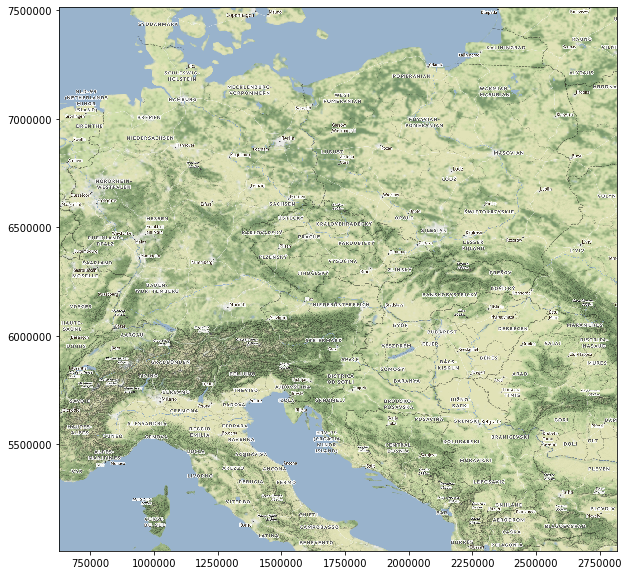

In [5]:
ZOOM_LEVEL = 8
w, s, e, n = 6, 43, 24, 54.5

# check number of tiles that will be downloaded
ctx.howmany(w, s, e, n, ZOOM_LEVEL, ll=True)

# download tiles
%time img, ext = ctx.bounds2img(w, s, e, n, ZOOM_LEVEL-1, ll=True)

# plot map 
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(img, extent=ext, aspect='auto')

In [6]:
con = psycopg2.connect(database="skoda-postgres", user="root", password="sumpr0ject",
    host="localhost", port=35432)
# A function that takes in a PostgreSQL query and outputs a pandas database 
def create_pandas_table(sql_query, database = con):
    table = pd.read_sql_query(sql_query, database)
    return table

def create_geopandas_table(sql_query, database = con,geom_col='geom', crs='wgs84' ):
    table = GeoDataFrame.from_postgis(sql_query, database, geom_col=geom_col, crs=crs)
    return table

  

***Rides***

The table rides contains the original point records. Each point is a spatiatially referenced, there is a record timestamp and the carid defines the vehicles that the record belongs to.

In [7]:
sql = "SELECT * FROM points LIMIT 100;"
rides = GeoDataFrame.from_postgis(sql, con, geom_col='geom' , crs='wgs84', parse_dates='datetime')
rides.head()

,carid,datetime,geog,geom
0,524305,2019-05-13 07:10:27,0101000020E6100000C8EA56CF49D72D40EB1B98DC2836...,POINT (14.92048 50.42312)
1,524305,2019-05-13 07:10:33,0101000020E61000008BA9F413CED62D40292499D53B36...,POINT (14.91954 50.42370)
2,524305,2019-05-13 07:10:53,0101000020E6100000F83768AF3ED62D40547078414436...,POINT (14.91845 50.42396)
3,524305,2019-05-13 07:11:02,0101000020E6100000BF27D6A9F2D52D405D4E09884936...,POINT (14.91787 50.42412)
4,524305,2019-05-13 07:11:40,0101000020E6100000C89750C1E1D52D4069C878944A36...,POINT (14.91774 50.42415)


In [8]:
cursor = con.cursor()
query = "select count(*) from points"
cursor.execute(query)
num1 = cursor.fetchone()
print("There are " + str(num1[0]) + " recored points in database")
query = "select count(distinct carid) from points"
cursor.execute(query)
num2 = cursor.fetchone()
print("There are " + str(num2[0]) + " unique users in database")
query = "select count(distinct tripid) from trajectories"
cursor.execute(query)
num3 = cursor.fetchone()
print("There are " + str(num3[0]) + " trips in database")

There are 462 recored points in database
There are 1 unique users in database
There are 13 trips in database


In [9]:
cursor = con.cursor()
temp_filter_may = "datetime between '2019-05-01' and '2019-06-01'"
temp_filter_may10 = "datetime between '2019-05-10' and '2019-05-11'"
temp_filter_may = "datetime between '2019-05-01' and '2019-06-01'"
temp_filter_all = "TRUE"

In [10]:
query = "select count(distinct carid) from points where {};".format(temp_filter_all)
cursor.execute(query)
cursor.fetchall()

[(1,)]

In [11]:
query = "select count(*) from points where {};".format(temp_filter_may10)
cursor.execute(query)
cursor.fetchall()

[(0,)]

In [12]:
query = "select * from areas"
areas = create_geopandas_table(query)
areas.head()

DatabaseError: Execution failed on sql 'select * from areas': relation "areas" does not exist
LINE 1: select * from areas
                      ^


In [ ]:
q = "SELECT count(points.*), areas.nazok_a FROM rides join areas on ST_WITHIN(points.geom::geometry, areas.geom) group by nazok_a order by count desc"
d = create_pandas_table(q)
d

In [14]:
sql = "SELECT * FROM charging_points;"
charging_points = GeoDataFrame.from_postgis(sql, con, geom_col='geom', crs='wgs84' )

charging_points.head()

IndexError: too many indices for array

Empty GeoDataFrame
Columns: [pointid, numac_smart, numac_dc, location, geog, geom]
Index: []

In [15]:
sql = "SELECT * FROM trajectories LIMIT 10;"
trajectories = GeoDataFrame.from_postgis(sql, con, geom_col='geom', crs='wgs84' )
trajectories.head()

,tripid,carid,geom
0,0,524305,"LINESTRING (14.92048 50.42312, 14.91954 50.423..."
1,1,524305,"LINESTRING (14.92083 50.42300, 14.92089 50.423..."
2,2,524305,"LINESTRING (14.92057 50.42322, 14.92057 50.423..."
3,3,524305,"LINESTRING (14.89810 50.40923, 14.89918 50.409..."
4,4,524305,"LINESTRING (14.92111 50.42311, 14.92119 50.423..."


In [16]:
trajectories.distance()

TypeError: distance() missing 1 required positional argument: 'other'

In [17]:
sql = "SELECT * FROM trips_points LIMIT 1000;"
trip_points = GeoDataFrame.from_postgis(sql, con, geom_col='geom', crs='wgs84')
trip_points.head()


,tripid,carid,datetime,geom
0,0,524305,2019-05-13 07:10:27,POINT (14.92048 50.42312)
1,0,524305,2019-05-13 07:10:33,POINT (14.91954 50.42370)
2,0,524305,2019-05-13 07:10:53,POINT (14.91845 50.42396)
3,0,524305,2019-05-13 07:11:02,POINT (14.91787 50.42412)
4,0,524305,2019-05-13 07:11:40,POINT (14.91774 50.42415)


In [18]:
sql = "SELECT * FROM end_points;"
end = GeoDataFrame.from_postgis(sql, con, geom_col='geom', crs='wgs84' )
end.head()

# sql = "SELECT * FROM rides WHERE carid IN ('524305','536208') AND recorddatetime BETWEEN '2019-05-10' AND '2019-05-11';"

,tripid,carid,geom
0,3,524305,POINT (14.92042 50.42303)
1,4,524305,POINT (14.92033 50.42304)
2,12,524305,POINT (14.92040 50.42299)
3,8,524305,POINT (14.92044 50.42308)
4,10,524305,POINT (14.92036 50.42305)


In [19]:
q = "select nn.pointid, n.* from end_points as n,(SELECT * from end_points as m, charging_points as ch where m.tripid = tripid  ORDER BY m.geom::geography <-> ch.geom::geography ASC limit 1 ) as nn LIMIT 5000"
d = create_geopandas_table(q, geom_col = 'geom')
d

IndexError: too many indices for array

Empty GeoDataFrame
Columns: [pointid, tripid, carid, geom]
Index: []

In [ ]:
q = "select ch.pointid,tripid, m.geom, m.geom::geography <-> ch.geom::geography as dist from charging_points as ch, end_points as m where m.geom::geography <-> ch.geom::geography < 300 ORDER by tripid, dist ASC"
d = create_geopandas_table(q, geom_col = 'geom')
d

In [ ]:
d.plot(column=None, legend=True, figsize=(10,10))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=13)

In [ ]:
ax = charging_points.to_crs(epsg=3857).plot(column=None, legend=True, figsize=(10,10))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=13)

In [ ]:
ax = trip_points.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(10,10))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=13)

In [ ]:
ax = trip_points.to_crs(epsg=3857).plot(column='tripid', legend=True, figsize=(10,10))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=13)

In [ ]:
rides['carid'].unique()

### Trips stats

In [20]:
sql = "select tripid, carid, (ST_Length(geom::geography)/1000) as length from trajectories order by length desc;"
trips_length = pd.read_sql_query(sql, con )
trips_length

,tripid,carid,length
0,10,524305,10.972669
1,8,524305,7.338471
2,0,524305,4.249801
3,2,524305,3.372925
4,3,524305,3.298377
5,11,524305,2.629980
6,4,524305,2.520606
7,12,524305,2.101774
8,9,524305,2.024426
9,1,524305,1.981558


In [21]:
print("Average trips length: " + str(trips_length['length'].mean()))

Average trips length: 3.46076919294961
